In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import(ConfusionMatrixDisplay,
                           classification_report,
                           confusion_matrix) 
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline

In [15]:
#Generate wrangle function
def wrangle(filepath):
    #read csv file and set index to ID
    df = pd.read_csv(filepath, low_memory=False)
    #drop unwanted  URL columns
    df.drop(columns=["Source","Source_II","Source_III","Source_IV","Source_V","Source_VI","Source_VII"], inplace=True)
    #drop insignificant columns with extremely high null values and high autocorrelation
    df.drop(columns=["Genomics_Metadata","Country_ISO3","City","Date_onset","Hospitalised (Y/N/NA)",
                     "Date_hospitalisation","Isolated (Y/N/NA)","Date_isolation",
                     "Outcome","Contact_comment","Contact_ID","Contact_location",
                     "Date_death","Travel_history_entry","Travel_history_start","ID", "Location", "Travel_history_location"], inplace=True)
    #drop rows contontaining https://www.publichealthontario.ca/-/media/Documents/M/2022/monkeypox-episummary.pdf?sc_lang=en"
    df.drop(df.index[df["Status"]=="https://www.publichealthontario.ca/-/media/Documents/M/2022/monkeypox-episummary.pdf?sc_lang=en"], inplace=True)
    #drop rows with extreme null values ie rows containing status == omit_error
    df.drop(df.index[df["Status"]=="omit_error"], inplace=True)
    #drop rows containing discarded cases of monkeypox
    df.drop(df.index[df["Status"]=="discarded"], inplace=True)
    df.drop(df.index[df["Gender"]=="2022-06-03"], inplace=True)
    #fill null values according to the mode of suspected  and confirmed cases
    df["Status"] = df["Status"].fillna("confirmed")
    df.loc[df["Status"]=="confirmed"] = df.loc[df["Status"]=="confirmed"].fillna({"Symptoms":df.Symptoms.mode()[0],
                                                                                 "Gender":df.Gender.mode()[0],
                                                                                 "Age":df.Age.mode()[0],
                                                                                 "Confirmation_method":df.Confirmation_method.mode()[0]})
    df.loc[df["Status"]=="suspected"] = df.loc[df["Status"]=="suspected"].fillna({"Symptoms":"rash, fever",
                                                                                 "Age":"0-39",
                                                                                 "Gender":"Female",
                                                                                 "Confirmation_method":df.Confirmation_method.mode()[0]})
    #fill null values for all other columns
    df["Travel_history (Y/N/NA)"] = df["Travel_history (Y/N/NA)"].fillna("Y")
    df["Country"] = df["Country"].fillna(df["Country"].mode()[0])
    df["Travel_history_country"] = df["Travel_history_country"].fillna(df["Travel_history_country"].mode()[0])
    df["Date_last_modified"] = df["Date_last_modified"].fillna(df["Date_last_modified"].mode()[0])
    df["Date_confirmation"] = df["Date_confirmation"].fillna(df["Date_confirmation"].mode()[0])
    df["Date_entry"] = df["Date_entry"].fillna(df["Date_entry"].mode()[0])
    #convert time series object to datetime
    #df["Date_last_modified"] = pd.to_datetime(df["Date_last_modified"], format="%Y-%m-%d")
    #df["Date_confirmation"] = pd.to_datetime(df["Date_confirmation"], format="%Y-%m-%d")
    #df["Date_entry"] = pd.to_datetime(df["Date_entry"], format="%Y-%m-%d")


   #drop duplicate rows
    df.drop_duplicates(keep="first",inplace=True)


    return df

In [16]:
df = wrangle("Monkeypox_df.csv")

In [17]:
df.head()

,Status,Country,Age,Gender,Date_confirmation,Symptoms,Travel_history (Y/N/NA),Travel_history_country,Confirmation_method,Date_entry,Date_last_modified
0,confirmed,England,20-69,Male,2022-05-06,rash,Y,Nigeria,RT-PCR,2022-05-18,2022-05-18
1,confirmed,England,20-69,Male,2022-05-12,rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
2,confirmed,England,20-69,Male,2022-05-13,vesicular rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
3,confirmed,England,20-69,Male,2022-05-15,vesicular rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
6,confirmed,England,20-69,Male,2022-05-15,vesicular rash,Y,England,RT-PCR,2022-05-18,2022-05-18


In [18]:
#get train and test data 
target = "Status"
X = df.drop(columns="Status")
y = df[target]

In [19]:
X.shape

(2004, 10)

In [20]:
y.shape

(2004,)

In [21]:
#perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
#Resample data due to imbalance
Undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = Undersampler.fit_resample(X_train, y_train)
Oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = Oversampler.fit_resample(X_train, y_train)

In [23]:
#check class balance between oversampled and undersampled data
print("class balance for over sampled data:",y_train_over.value_counts(normalize=True))
print("class balance for undersampled data:",y_train_under.value_counts(normalize=True))

class balance for over sampled data: confirmed    0.5
suspected    0.5
Name: Status, dtype: float64
class balance for undersampled data: confirmed    0.5
suspected    0.5
Name: Status, dtype: float64


In [24]:
#build baseline model
acc_baseline = y_train.value_counts(normalize=True).max()
print("baseline score:", acc_baseline)

baseline score: 0.978601997146933


In [25]:
#fit model into training data to get best performing data for model building
#X_train, y_train
model_reg = make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(random_state=42))
model_reg.fit(X_train,y_train)
#X_train_over, y_train_over
model_over = make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(random_state=42))
model_over.fit(X_train_over,y_train_over)
#X_train_under, y_train_under
model_under = make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(random_state=42))
model_under.fit(X_train_under,y_train_under)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Country', 'Age', 'Gender',
                                      'Date_confirmation', 'Symptoms',
                                      'Travel_history (Y/N/NA)',
                                      'Travel_history_country',
                                      'Confirmation_method', 'Date_entry',
                                      'Date_last_modified'],
                                mapping=[{'col': 'Country',
                                          'data_type': dtype('O'),
                                          'mapping': Italy                                1
Slovenia                             2
Honduras                             3
Spain                                4
Portugal                             5
Ireland                              6
Czech Republic                       7
United States...
2022-07-07    18
2022-08-23    19
2022-06-21    20
2022-06-29    21
2022-07-19    22
2022-08-24    23
2022-07-14    24
2022-05-18    25
2022-08-02    26
2022-07-27    27
2022-08-16    28
2022-07-28    29
2022-06-11    30
2022-07-29    31
2022-07-18    32
2022-07-20    33
2022-06-04    34
2022-05-29    35
2022-08-19    36
2022-05-26    37
2022-07-21    38
2022-06-03    39
NaN           -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [26]:
#get best performing data
for model in [model_reg,model_over,model_under]:
    #get train score
    train_score = model.score(X_train,y_train)
    #get test score
    test_score = model.score(X_test, y_test)
    
    print("train score:",train_score)
    print("test score:", test_score)

train score: 1.0
test score: 0.9983388704318937
train score: 1.0
test score: 0.9983388704318937
train score: 1.0
test score: 1.0


To avoid errors and bias we get the best performing model from the resampled data, i choose the model from the oversampled data
that conforms to real life scenarios bcs there's no perfect model in real life

In [27]:
#get tree depth
model_over.named_steps["decisiontreeclassifier"].get_depth()

3

In [28]:
#Communicate model by getting feature importances
features = model_over.named_steps['decisiontreeclassifier'].feature_importances_
Feature_Importance = pd.Series(features, index=X_train_over.columns).sort_values()

In [29]:
Feature_Importance

Country                    0.000000
Age                        0.000000
Symptoms                   0.000000
Travel_history (Y/N/NA)    0.000000
Travel_history_country     0.000000
Confirmation_method        0.000000
Date_entry                 0.000000
Date_confirmation          0.021835
Date_last_modified         0.053331
Gender                     0.924835
dtype: float64

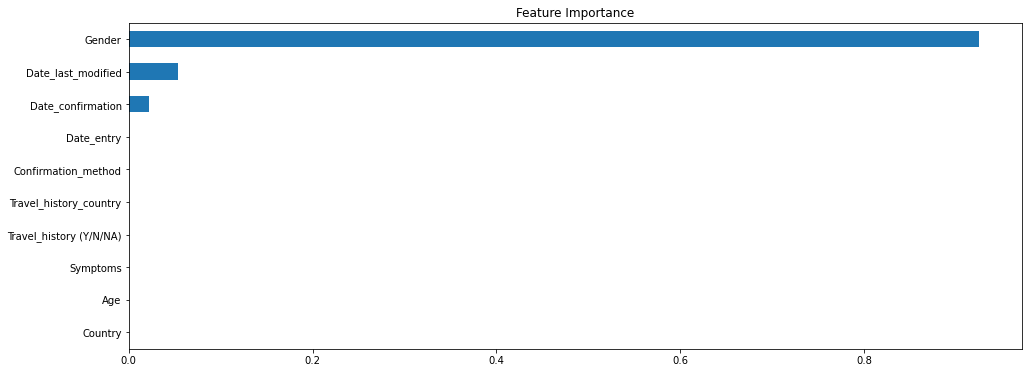

In [30]:
#visualize feature importance
fig,ax = plt.subplots(figsize=(16,6))
Feature_Importance.plot.barh(title="Feature Importance");

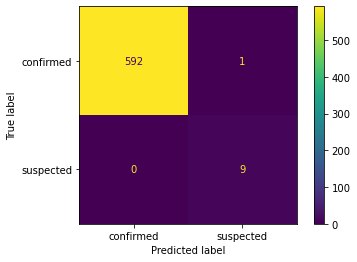

In [31]:
#plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test);

In [32]:
#classification report
print(classification_report(y_test, model_over.predict(X_test)))

              precision    recall  f1-score   support

   confirmed       1.00      1.00      1.00       593
   suspected       0.90      1.00      0.95         9

    accuracy                           1.00       602
   macro avg       0.95      1.00      0.97       602
weighted avg       1.00      1.00      1.00       602

